# Quantifying Repetition

**update 5 Oct** Following Stabler's suggestion, let's distinguish between repetition and copying. 

* **Repetition** is the occurrence of adjacent identical substrings, and hence is defined on the surface level (observed sentences) rather than on the level of the grammar.
* **Copying** is when material is reproduced on the level of the grammar, in particular due to the application of a kind of copy rule. Hence "copying" is defined on the level of the grammar. Copying will certainly lead to repetition on the surface, but repetition is not necessarily due to copying; for example a pure bigram grammar that doesn't have a copy rule might yield repetition on the surface simply because a series of bigrams is repeated, by chance.

Our main question here is: How can we quantify the amount of repetition that is going on in a particular sentence in a way that does not depend on the particular type of grammar under consideration? Simply given a sentence, is there a metric that quantifies the amount of repetition?

The importance of having such a quantity that is independent of a particular type of grammar, is that we can ask whether the advantage of the Copy rule in a particular grammar can be explained by the observed repetition or not? Furthermore, we can establish baseline repetition quantities using permutation tests.

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from misc import *
import scipy.stats as st

import seaborn as sns
sns.set_style("ticks")

Populating the interactive namespace from numpy and matplotlib


## Example

Let's do an example. Suppose we are given the following sentence:

In [2]:
sentence = "aiw aix aiw aix aiw aix aiw aix".split(" ")

In [3]:
print(sentence)

['aiw', 'aix', 'aiw', 'aix', 'aiw', 'aix', 'aiw', 'aix']


One approach would be to list all possible substrings that could be the result of repeats because they are followed by an exact repetition. In the "repetition list" that is generated below, each tuple (i,n) means that there is a repetition starting at index i, of length n, i.e. that the substring (i,i+n) is identical to (i+n,i+2n).

In [4]:
def find_repetitions(sentence):
    copies = []
    for i in range(len(sentence)-1):                   # loop over position in sentence
        for n in range(1,((len(sentence)-i)//2)+1):     # loop over substrings
            if sentence[i:i+n]==sentence[i+n:i+(2*n)]: # if we detect a repetition...
                copies.append( (i,n) )
    return copies

repetitions = find_repetitions(sentence)

In [5]:
repetitions

[(0, 2), (0, 4), (1, 2), (2, 2), (3, 2), (4, 2)]

Note that some of these repetitions overlap. And there is some redundancy: if we know that (0,2) is a repeat and (0,4) is a repeat, then (4,2) is necessarily also a repeat. As an illustration, here below we present the repeats, where the left hand sides are marked in red and the repeated instances in gray.

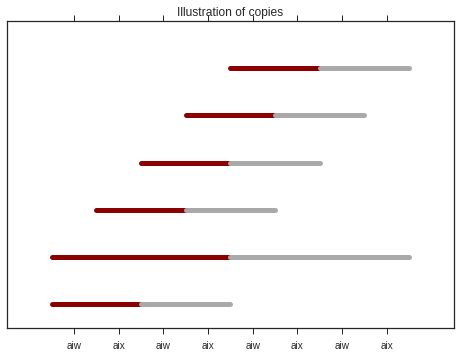

In [6]:
for n,(i,j) in enumerate(repetitions):
    plt.plot([i,i+j],[n,n],color="darkred",lw=5)
    plt.plot([i+j,i+(2*j)],[n,n],color="darkgray",lw=5)
plt.xticks(np.arange(len(sentence))+.5,sentence)
plt.xlim(-1,len(sentence)+1)
plt.ylim(-.5,len(repetitions))
plt.yticks([],[])         
plt.title("Illustration of copies")

Let's say we are interested in quantifying the total amount of repetition. One way would be to compute, for each repetition, the number of words that are copied, and then sum those for every word.

In [7]:
n_repetitions = len(repetitions)
repeated_total = sum([ n for (_,n) in repetitions ])

print ("Total repeated material %i"%repeated_total)
print ("Number of repetitions %i"%n_repetitions)
print ("Avg # of words per repeat %.2f"%(repeated_total/float(n_repetitions)))
print ("Amount of repeating per word %.2f"%(repeated_total/float(len(sentence))))

Total repeated material 14
Number of repetitions 6
Avg # of words per repeat 2.33
Amount of repeating per word 1.75


## Original Corpus (CATH8)

So how much repetition is going on in the CATH8 corpus? 

In [8]:
# The file that contains the base corpus
INPUT_FILE = "../corpus/cath8.txt"

# Read the input file and obtain a list of list of strings, i.e. the list of sentences
f = open(INPUT_FILE,'r')
lines = f.readlines()
f.close()
cath8 = [ l.strip().split(" ") for l in lines ]

In [9]:
all_repeats = []

perword = pd.DataFrame([])
for i,sentence in enumerate(cath8):
    repetitions = find_repetitions(sentence)
    all_repeats += repetitions # append the copies to the existing big list
    
    n_repetitions = len(repetitions)
    repeated_total = sum([ n for (_,n) in repetitions ])
    
    perword = pd.concat([perword,
                         pd.DataFrame({"sentence":[".".join(sentence)],
                                       "length":[len(sentence)],
                                       "total.repeated.material":[repeated_total],
                                       "number.of.repetitions":[n_repetitions],
                                       "n.words.per.repeat":[(repeated_total/float(n_repetitions))],
                                       "repetitions.per.word":[repeated_total/float(len(sentence))]
                                       })])

To get an idea of what this looks like for a few example sentences:

In [10]:
perword.iloc[:10]

,length,n.words.per.repeat,number.of.repetitions,repetitions.per.word,sentence,total.repeated.material
0,10,3.000000,3,0.900000,aiu.ago.ait.ago.ait.aiu.ago.ait.ago.ait,9.0
0,5,2.000000,1,0.400000,aiv.aiw.aix.aiw.aix,2.0
0,6,2.000000,1,0.333333,aiw.aix.aiw.aix.aiy.aiu,2.0
0,10,2.000000,2,0.400000,ait.ago.ait.ago.ait.aiz.aja.aiz.aiu.ago,4.0
0,1,NaN,0,0.000000,ait,0.0
0,4,2.000000,1,0.500000,aiw.aix.aiw.aix,2.0
0,11,1.666667,3,0.454545,ajc.aiu.ago.ait.ago.ait.ago.ago.ait.aiu.ago,5.0
0,3,1.000000,1,0.333333,aiw.aiw.aix,1.0
0,1,NaN,0,0.000000,aiu,0.0
0,10,2.000000,2,0.400000,ait.aiw.aix.aiw.aix.aiy.ajd.aiy.ajd.aiu,4.0


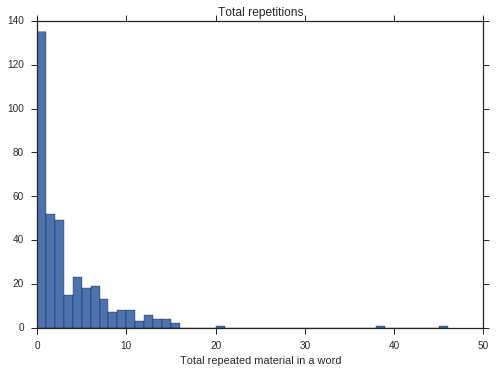

In [11]:
totrep= list(perword["total.repeated.material"])
res = plt.hist(totrep,bins=range(int(max(totrep))+1))
plt.xlabel("Total repeated material in a word")
plt.title("Total repetitions")

There are a few outliers with huge amounts of repetition:

In [12]:
perword[ perword["total.repeated.material"]>19]

,length,n.words.per.repeat,number.of.repetitions,repetitions.per.word,sentence,total.repeated.material
0,17,3.166667,12,2.235294,bba.bba.bbb.bbc.bba.bbb.bbc.bba.bbb.bbc.bba.bb...,38.0
0,17,3.538462,13,2.705882,bba.bbb.bbc.bba.bbb.bbc.bba.bbb.bbc.bba.bbb.bb...,46.0
0,17,2.222222,9,1.176471,bbf.bbd.bbf.bbd.bbf.bbd.bbf.bbd.bbg.bbh.bbg.bb...,20.0


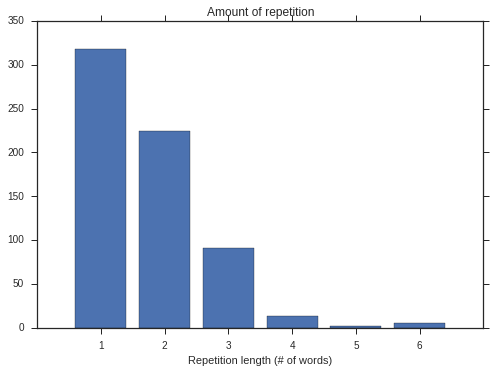

In [13]:
# Had to do this by hand due to something that looks like a bug in plt.hist
repetitions_lengths = [ n for (_,n) in all_repeats ]
repetition_ls = np.array(list(set(repetitions_lengths)))
amounts = [ len([ n for n in repetitions_lengths if n==c]) for c in repetition_ls ]

maxc = max(repetitions_lengths)
#bs = np.arange(maxc+1)
#res = plt.hist(list(copies_lengths),bins=bs)
plt.bar(repetition_ls-.4,amounts,width=.8)
plt.xticks(repetition_ls,repetition_ls)
#res = plt.hist(copies_lengths)
#plt.xticks(bs+.5,bs)
plt.xlabel("Repetition length (# of words)")
plt.title("Amount of repetition")

As you can see, there are no repetitions of length more than 6 words.

Total number of copied words in the corpus:

In [14]:
sum([ n for (_,n) in all_repeats ])

1137

In [15]:
import quantify_copying
cath8copy = quantify_copying.corpus(cath8)
print (cath8copy)

{'n.unique.sentences': 325, 'n.corpus.words': 2618, 'n.sentences': 369, 'repetitions.per.word': 0.4343009931245225, 'total.repeated.material': 1137, 'n.repetitions': 655, 'words.per.repeat': 1.7358778625954199}


## Repetition for various prefix lengths

Ok, enter Meaghan, who wonders how repetition might depend on the prefix length. That is, if we have a prefix of length n, what are possible copies?

In [16]:
rep_lengths = {}
prefixes = range(1,max([len(s) for s in cath8]))
repetition_prefix = np.array([ [ np.nan for _ in prefixes ] for _ in prefixes ])

for prefix_length in prefixes:

    # Go through all repetitions and find those where the prefix (the point 'between' the two repetitions) is 5. 
    # Note that I've encoded repetitions as (i,n) meaning that substring from i to i+n is the same as from i+n to i+2n.
    selections = [ (i,n) for (i,n) in all_repeats if i+n==prefix_length ]
    
    # Now aggregate them by repetition length
    repetition_lengths = np.arange(prefix_length)+1
    n_repeats_per_length = [ len([ (i,n) for (i,n) in selections if n==rep_len ]) for rep_len in repetition_lengths ]
    rep_lengths[prefix_length]=n_repeats_per_length    
    
    for rep_len in repetition_lengths:
        repetition_prefix[prefix_length-1][rep_len-1]= len([ (i,n) for (i,n) in selections if n==rep_len ])
    
    #print ("Prefix length: %i --"%prefix_length)
    #print ("Repeats by repetition length:",n_repeats_per_length)
    
    #rep_lengths[prefix_length]=n_repeats_per_length
repetition_prefix

array([[ 64.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan],
       [ 46.,  41.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan],
       [ 32.,  43.,  15.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan],
       [ 29.,  25.,  12.,   3.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan],
       [ 17.,  24.,  14.,   2.,   2.,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan],
       [ 25.,  15.,  17.,   1.,   0.,   1.,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan],
       [ 19.,  11.,  10.,   1.,   0.,   2.,   0.,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan],
       [ 13.,  12.,   7.,   1.,   0.,   2.,   0.,   0.,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan],
       [ 10.,   9.,   5.,   2.,   0.,   0.,   0.,   0.,   0.,  nan,  nan,
         nan,  nan,  n

Here is that same thing in graph form. As expected, the longest repeats happen in intermediate length sentences, because then you have enough material before to repeat and enough "space" after to insert the repeated stuff.

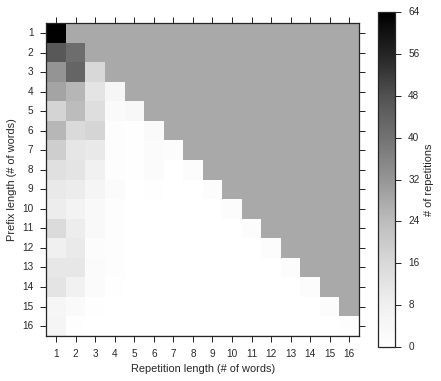

In [17]:
f = plt.figure(figsize=(7,6))
ax = plt.subplot(111,axisbg='darkgray')
cax = ax.imshow(repetition_prefix,interpolation='None')
ax.set_xlabel("Repetition length (# of words)")
ax.set_ylabel("Prefix length (# of words)")
plt.yticks(range(len(repetition_prefix)),   np.arange(len(repetition_prefix))+1)
plt.xticks(range(len(repetition_prefix[0])),np.arange(len(repetition_prefix[0]))+1)
#              [ i+1 for i in range(len(repetition_prefix))])
f.colorbar(cax,label="# of repetitions")

Here below the same thing, but rescaling by the total number of copies for each prefix length. So we see a "breakdown" of repetition lengths

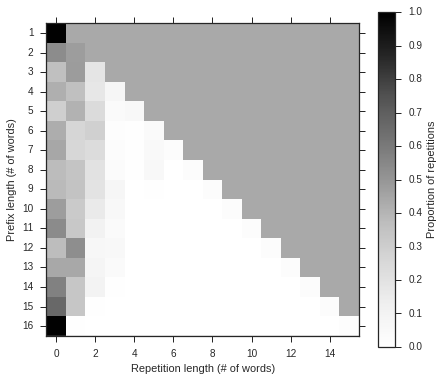

In [18]:
def nona_sum(x): 
    v = [ i for i in x if not np.isnan(i) ]
    if len(v)>0: 
        return sum(v)
    else: 
        return 0.
f = plt.figure(figsize=(7,6))
ax = plt.subplot(111,axisbg='darkgray')
rep_rescaled = [ repetition_prefix[i]/nona_sum(repetition_prefix[i]) for i in range(len(repetition_prefix)) ]
cax = ax.imshow(rep_rescaled,interpolation='None')
ax.set_xlabel("Repetition length (# of words)")
ax.set_ylabel("Prefix length (# of words)")
plt.yticks(range(len(repetition_prefix)),np.arange(len(repetition_prefix))+1)
f.colorbar(cax,label="Proportion of repetitions")

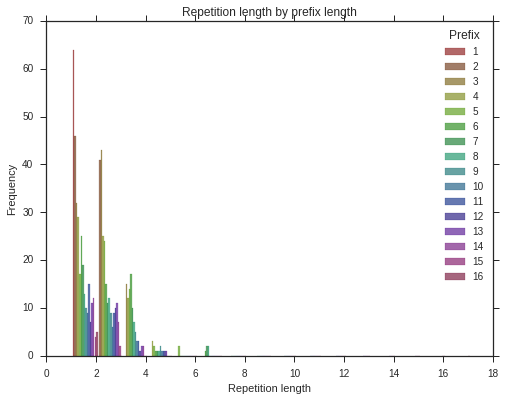

In [19]:
from misc import *
cols = get_colors(len(prefixes))
plt.figure(figsize=(8,6))

for prefix_length in prefixes:
    
    sels = rep_lengths[prefix_length]
        
    plt.bar((float(prefix_length)/len(prefixes))+np.arange(len(sels))+1,
            sels,
            color=cols[prefix_length-1],edgecolor=cols[prefix_length-1],width=(1.0/len(prefixes)),
            alpha=.6,label=prefix_length)
    #.set_title("Prefix length %i"%(prefix_length))

plt.xlabel("Repetition length")
plt.ylabel("Frequency")
plt.title("Repetition length by prefix length")
plt.legend(title="Prefix")

In [20]:
"""
from misc import *
fig, axs = plt.subplots(len(prefixes), 1, sharex=True, sharey=True,figsize=(8,9.5))
cols = get_colors(len(prefixes))

for prefix_length in prefixes:
    
    ax = axs[prefix_length-1]
    sels = rep_lengths[prefix_length]
        
    ax.bar(range(1,len(sels)+1),
           sels,
           color=cols[prefix_length-1],edgecolor=cols[prefix_length-1],width=.8)
    ax.set_title("Prefix length %i"%(prefix_length))

plt.xlabel("Repetition length")
plt.ylabel("Frequency")
"""

'\nfrom misc import *\nfig, axs = plt.subplots(len(prefixes), 1, sharex=True, sharey=True,figsize=(8,9.5))\ncols = get_colors(len(prefixes))\n\nfor prefix_length in prefixes:\n    \n    ax = axs[prefix_length-1]\n    sels = rep_lengths[prefix_length]\n        \n    ax.bar(range(1,len(sels)+1),\n           sels,\n           color=cols[prefix_length-1],edgecolor=cols[prefix_length-1],width=.8)\n    ax.set_title("Prefix length %i"%(prefix_length))\n\nplt.xlabel("Repetition length")\nplt.ylabel("Frequency")\n'

### Single-syllable repeats


At SfN today (16.11.2014) I saw a poster by Wittenbach and Brainard and others and they noticed repetition on a single-syllable basis. What they noticed was that with Markov chains, you can get this kind of repetition, but only with decreasing probability for increasing repetition, i.e. A and AA and AAA and AAAA have monotonically decreasing probabilities. In reality, they found that at ~8 repetitions there was a maximum. This made me wonder how our single syllable repeats are distributed.

In [21]:

def single_syll_repeats(sentence):
    copies = []
    i = 0
    while i<len(sentence):
        n = i
        while n<len(sentence) and sentence[n]==sentence[i]:
            n+=1 # increase count
        if n>i:
            copies.append( (sentence[i],i,n-i) )
        i=n
    return copies

single_syll_repeats(sentence)


[('acb', 0, 1),
 ('ace', 1, 1),
 ('ave', 2, 1),
 ('aut', 3, 2),
 ('aob', 5, 3),
 ('ave', 8, 1)]

In [22]:
allreps = []
for sentence in cath8:
    allreps+=single_syll_repeats(sentence)

Below we plot the number of repeats for various syllables (each line is a syllable). We restrict our attention to syllables that occur relatively often.

In [23]:
# First, determine which syllables occur often enough to be of interest
whole_corpus = []
for s in cath8:
    whole_corpus+=s

unigram_freqs = get_freqs(whole_corpus)

unigrams_selected = [ u for (u,cnt) in unigram_freqs if cnt>80 ]

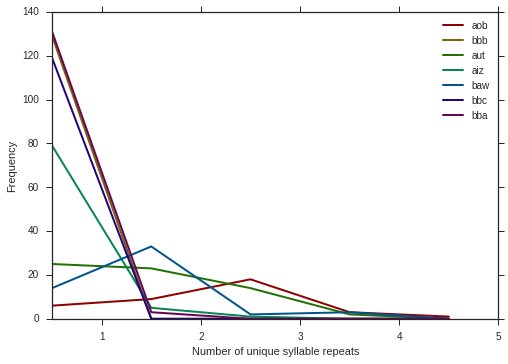

In [24]:
# Here we plot the repeat curves for the selected unigrams
colors = get_colors(len(unigrams_selected))

lengths = list(set([ l for (_,_,l) in allreps ]))
for j,unigr in enumerate(unigrams_selected):
    freqs = [ len([ i for (u,i,l) in allreps if l==length and u==unigr ]) for length in lengths ]
    plt.plot( lengths, freqs, label=unigr, color=colors[j], lw=2 )

plt.xticks( np.array(lengths)+.5, lengths )
plt.xlabel("Number of unique syllable repeats")
plt.ylabel("Frequency")
plt.legend()


Here are the repeat lengths for all syllables taken together.

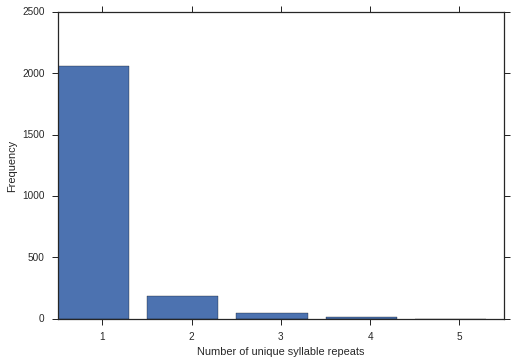

In [25]:
lengths = list(set([ l for (_,_,l) in allreps ]))
freqs = [ len([ i for (_,i,l) in allreps if l==length ]) for length in lengths ]
plt.bar( lengths, freqs )
plt.xticks( np.array(lengths)+.5, lengths )
plt.xlabel("Number of unique syllable repeats")
plt.ylabel("Frequency")


All right, so I don't think there's evidence for single-syllable repeating being specially controlled (other than markov chains I guess). 

# Copying in Randomly Generated Corpora

So how much repetition is going on in the permuted corpora? And in the bigram-generated corpora? As a further check we also generate a corpus using bigrams, but this time we don't impose any length requirements on the individual words: we just randomly walk through our bigram transition matrix, generating words, and stopping when we have a corpus of approximately the same number of words as CATH8.

As control analysis, we verify whether our length criteria might have led to this amount of repetition. To check this, we include a bigram grammar that has no length restrictions on words. As another control analysis, we generate a corpus from a "flattened" bigram grammar in which all bigrams are equiprobable. Finally, I also include our bootstrap coropra, which should have approximately the same amount of repetition as CATH8.

In [26]:
# Generated by randomise.py
perm_stats      = pd.DataFrame.from_csv('interim/permutations_stats.csv')

# Generated by randomise_by_bigrams.py
bigr_stats      = pd.DataFrame.from_csv('interim/bigramgen_corpus_stats.csv') 
# bigram-selected sentences selected such that they have the same distribution of sentence lengths

# Generated by randomise_by_bigrams_free.py
bigr_free_stats = pd.DataFrame.from_csv('interim/bigramgen_free_corpus_stats.csv') 
# bigram-generated sentences that have no restriction on distribution of sentence lengths

# Generated by randomise_by_bigrams_free_flat.py
bigr_free_flat_stats = pd.DataFrame.from_csv('interim/bigramgen_free_flat_corpus_stats.csv') 
# bigram-generated sentences with flat distribution: all bigrams are equally likely

# Generated by randomise.py
bootstr_stats      = pd.DataFrame.from_csv('interim/bootstrap_corpora_stats.csv')

# Generated by randomise_within_sentences.py
perm_within_stats  = pd.DataFrame.from_csv('interim/permutations_within_sentences_stats.csv')

# The original corpus, generated by orig8_corpus_stats.py
cath8_orig = pd.DataFrame.from_csv('interim/cath8_stats.csv')

In [27]:
perm_stats["corpus"]          ="Permutation corpora"
bigr_stats["corpus"]          ="Bigram-generated corpora (sentence length matched)"
bigr_free_stats["corpus"]     ="Bigram-generated corpora (approx.corpus size matched)"
bigr_free_flat_stats["corpus"]="Bigram-generated corpora (flat: all bigrams equiprobable)"
bootstr_stats["corpus"]       ="Bootstrap corpora from CATH8"
perm_within_stats["corpus"]   ="Within-sentence permutations of CATH8"

fullstats = pd.concat([perm_stats,bigr_stats,bigr_free_stats,bigr_free_flat_stats,bootstr_stats,perm_within_stats])

In [28]:
bycorpus = fullstats.groupby('corpus')
#bycorpus["total.repeated.material"].describe()
summ = bycorpus["total.repeated.material"].agg({"N":len,"min":min,"mean":np.mean,"SD":np.std,"max":max})
summ["cath8.zscore"]=(cath8copy["total.repeated.material"]-summ["mean"])/(summ["SD"])
summ["cath8.pvalue"] = 1-st.norm.cdf(abs(summ["cath8.zscore"]))

Here is a table with, for each corpus, the specification of the amount of repetition (minimum, maximum, mean, standard deviation of total repetition in the corpus). Also, the z-score of cath8 relative to these distributions is given, and the corresponding p-value (one-tailed).

In [29]:
summ

,max,mean,SD,N,min,cath8.zscore,cath8.pvalue
corpus,,,,,,,
Bigram-generated corpora (approx.corpus size matched),3014,1936.426,262.308628,1000,1415,-3.047654,0.001153
Bigram-generated corpora (flat: all bigrams equiprobable),556,347.838,33.974255,1000,268,23.228236,0.000000
Bigram-generated corpora (sentence length matched),2330,1709.177,151.836992,1000,1338,-3.768364,0.000082
Bootstrap corpora from CATH8,1527,1134.149,86.307275,1000,873,0.033033,0.486824
Permutation corpora,80,56.869,7.265440,1000,31,148.666967,0.000000
Within-sentence permutations of CATH8,497,430.935,17.872162,1000,382,39.506411,0.000000


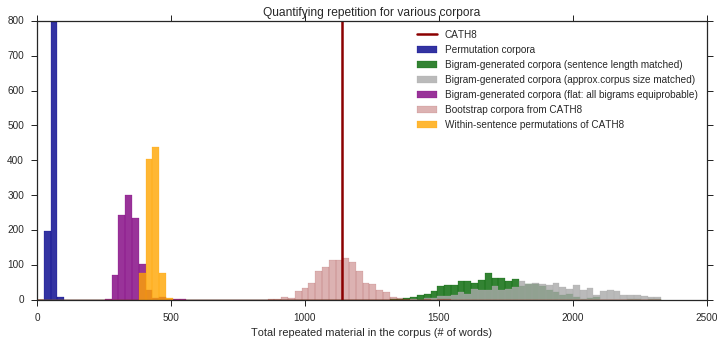

In [30]:
totalcop   = list(perm_stats["total.repeated.material"])
bigrcop    = list(bigr_stats["total.repeated.material"])
bigrcopfr  = list(bigr_free_stats["total.repeated.material"])
bigrcopfrfl= list(bigr_free_flat_stats["total.repeated.material"])
bootstrcop = list(bootstr_stats["total.repeated.material"])
permwcop   = list(perm_within_stats["total.repeated.material"])


maxcop = max(bootstrcop+totalcop+bigrcop+[cath8copy["total.repeated.material"]]#+bigrcopfr+bigrcopfrfl
             )

bins = np.linspace(0,maxcop,maxcop/25)
plt.figure(figsize=(12,5))
plt.hist(totalcop,bins=bins,color="darkblue",edgecolor="darkblue",
         label="Permutation corpora",alpha=.8)
plt.hist(bigrcop,bins=bins,color="darkgreen",edgecolor="darkgreen",
         label="Bigram-generated corpora (sentence length matched)",alpha=.8)
plt.hist(bigrcopfr,bins=bins,color="darkgray",edgecolor="darkgray",
         label="Bigram-generated corpora (approx.corpus size matched)",alpha=.8)
plt.hist(bigrcopfrfl,bins=bins,color="purple",edgecolor="purple",
         label="Bigram-generated corpora (flat: all bigrams equiprobable)",alpha=.8)
plt.hist(bootstrcop,bins=bins,color="darkred",edgecolor="darkred",
         label="Bootstrap corpora from CATH8",alpha=.3)
plt.hist(permwcop,bins=bins,color="orange",edgecolor="orange",
         label="Within-sentence permutations of CATH8",alpha=.8)
plt.axvline(x=cath8copy["total.repeated.material"],color="darkred",lw=2.5,label="CATH8")
plt.legend(loc="upper right")
plt.xlabel("Total repeated material in the corpus (# of words)")
plt.title("Quantifying repetition for various corpora")

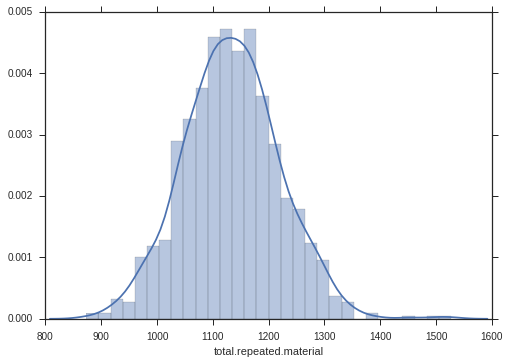

In [31]:
c = "Bootstrap corpora from CATH8"
sns.set_style("ticks")
sns.distplot(fullstats[ fullstats["corpus"]==c ]["total.repeated.material"])

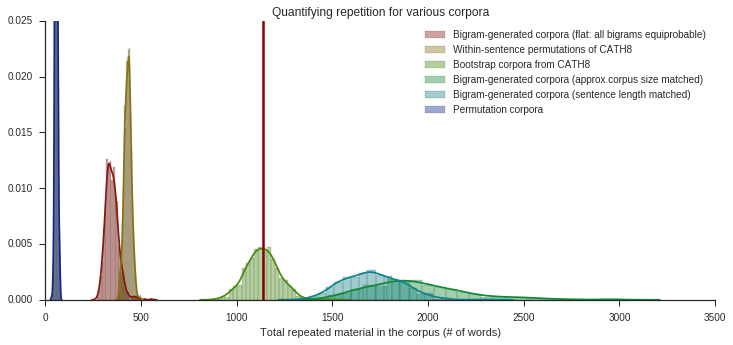

In [32]:
figure(figsize=(12,5))
sns.set_style("ticks")
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
for c in list(set(fullstats["corpus"])):
    subs = fullstats[ fullstats["corpus"]==c ]["total.repeated.material"]
    sns.distplot(subs,label=c)
ylim(0,.025)
sns.despine()
legend()
axvline(x=cath8copy["total.repeated.material"],color="darkred",lw=2.5,label="CATH8")
xlabel("Total repeated material in the corpus (# of words)")
title("Quantifying repetition for various corpora")

**Side-track** Does having more words in the corpus mean there will be more repetition? Recall that due to dropping the sentence-length restrictions, we now generate corpora of approximately the same size as CATH8, but not exactly. So is the final length of the corpus a predictor for the amount of repetition? (And is this a linear increase or something else?).

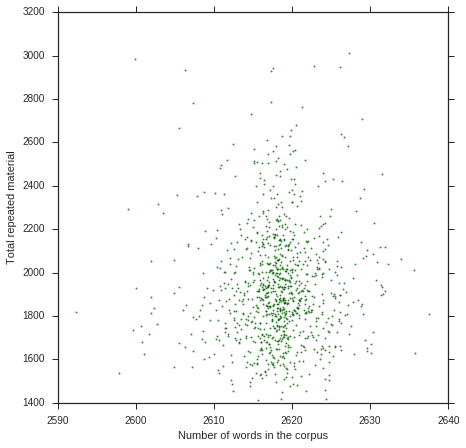

In [33]:
plt.figure(figsize=(7,7))
plt.plot(bigr_free_stats["n.corpus.words"]+random.normal(0,.4,len(bigr_free_stats)),
         bigr_free_stats["total.repeated.material"],
         'o',
         alpha=.8,markersize=1.9,mec="darkgreen",mfc="darkgreen")
plt.ylabel("Total repeated material")
plt.xlabel("Number of words in the corpus")

So it seems the relationship is not dramatic. This means we don't need to worry to much about the exact corpus size (plus or minus one word).

As another check: did we get up with approximately the right number of sentences?

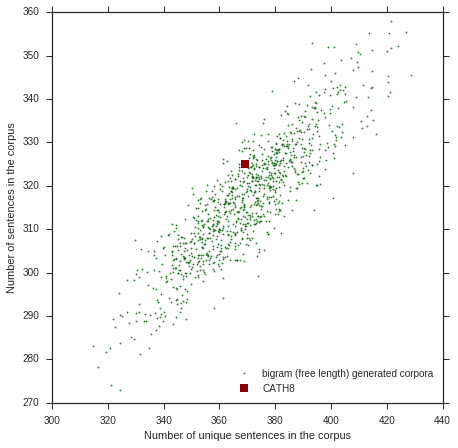

In [34]:
plt.figure(figsize=(7,7))
plt.plot(bigr_free_stats["n.sentences"]+random.normal(0,.4,len(bigr_free_stats)),
         bigr_free_stats["n.unique.sentences"]+random.normal(0,.4,len(bigr_free_stats)),
         'o',
         alpha=.8,markersize=1.9,mec="darkgreen",mfc="darkgreen",label="bigram (free length) generated corpora")
plt.plot(cath8copy["n.sentences"],
         cath8copy["n.unique.sentences"],'s',mec="darkred",mfc="darkred",markersize=8,label="CATH8")
plt.ylabel("Number of sentences in the corpus")
plt.xlabel("Number of unique sentences in the corpus")
plt.legend(loc="lower right")

### Side-track

A side-track: how many unique bigrams do we find in each of the randomisations mentioned above?

In [35]:
randomisations = [(perm_stats,"Permutation corpora"),
                  (bigr_stats,"Bigram-generated corpora (sentence length matched)"),
                  (bigr_free_stats,"Bigram-generated corpora (approx.corpus size matched)"),
                  (bigr_free_flat_stats,"Bigram-generated corpora (flat: all bigrams equiprobable)"),
                  (bootstr_stats,"Bootstrap corpora from CATH8"),
                  (perm_within_stats,"Within-sentence permutations of CATH8")]

quantity = "n.unique.bigrams"

report = []
for (distr,lbl) in randomisations+[(cath8_orig,"CATH8 original")]:
    vals = distr[quantity]
    m,s = np.mean(vals),np.std(vals)
    report.append( (lbl,m,s) )
    
report = pd.DataFrame(report)
report.columns = ["corpus","M.%s"%quantity,"SD.%s"%quantity]
report

,corpus,M.n.unique.bigrams,SD.n.unique.bigrams
0,Permutation corpora,1545.433,12.814894
1,Bigram-generated corpora (sentence length matc...,414.828,9.748149
2,Bigram-generated corpora (approx.corpus size m...,414.540,10.172138
3,Bigram-generated corpora (flat: all bigrams eq...,497.826,3.694012
4,Bootstrap corpora from CATH8,415.926,11.853629
5,Within-sentence permutations of CATH8,847.265,8.945657
6,CATH8 original,512.000,0.000000


## Our conclusions so far


* We introduce a **repetition metric** that quantifies how much material is repeated in a sentence (with the restriction that repeated material must be adjacent in the string). This metric is shown to be robust as evident from bootstrap-generated corpora, which yield similar amounts of repetition centered around the observed value for CATH8.
* Using our repetition metric, we are able to show that indeed permuted corpora have much less repetition. Still, they have a bit, but not as much as CATH8.
* When we use the observed bigram frequencies to randomly generate new corpora (with the same sentence lengths as CATH8) we find that they have **more** repetition than CATH8. This is surprising! It seems to suggest that repetition, in some cases, might be an epiphenomenon of bigram frequency structure. Except that if CATH8 were really a bigram-bird (i.e. emitting randomly according to bigram frequencies), we would expect it to repeat more than it actually does!
* This **bigram-induced repetition** appears to be encoded in the transitional probabilities rather than in the subset of legal bigrams (because if we "flatten" their distribution we don't observe as much repetition as CATH8 anymore).

The advantages of this metric are:
(i) it's a-theoretic, making no assumptions about bigram structure or probabilistic structure,
(ii) it's directly and straightforwardly calculated based on the observables; in particular it doesn't get stuck in potential local minima as the IO (EM) algorithm applied ot a grammar could.
(iii) it allows "fair" comparison of amount of repetition on corpora that have very different structure (e.g. very different bigram distributions).
(iv) it gives an "absolute" value of copying, instead of relative to something else, as is the case with the Bigram+Copy and Bigram grammars.
The disadvantages:
(i) it doesn't take into account that some of the repetitions mentioned above could overlap.
(ii) it doesn't reflect whether some of these repetition-parses may be more or less likely (one might argue that very long repetitions are less likely).
